# Calculations of SIA and SIE from observational datasets

### Author: Chris Wyburn-Powell, [github](https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_calculations_observations.ipynb)

**Input**: <br>
All datasets contain monthly data of which all months 1979-2020 are used
 - SIC: Merged Hadley NOAA Optimal Interpolation (OI)
 - SIC: HadISST1
 - SIC: HadISST2: N.B not currently updated beyond 2020-08 so is not used in subsequent analysis for now
 - SIC: NOAA/NSIDC Climate Data Record (CDR) Version 4, containing CDR, NASA Team (NT) and NASA Boostrap (BT) datasets
 - Time series: NSIDC sea ice index Version 3: monthly SIE and SIA
 
**Output**: <br>
- SIC 1979-2020 interpolated and np.nan-filled for: Merged Hadley_OI, HadISST1, HadISST2, CDR (CRD, NT, BT)
- SIA and SIE 1979-2020 interpolated for: Merged Hadley_OI, HadISST1, HadISST2, CDR (CRD, NT, BT), NSIDC sea ice index <br>

**Corrections/Interpolations**: <br>
Obejctive is to remove spurious data and fill missing data with values which are similar to what happened and/or represents a realistic spatial scenario - e.g. linear interpolation may be okay for SIA and SIE, but doing so for SIC could cause unrealistic spaital distributions to occur. 
- NOAA/NSIDC CDR version 4: Pole hole is filled using the average SIC of the surrounding grid cells (built in). Missing months 1984-07: values from 1985-07 used as complete datasets (HadISST1, NOAA-OI) show it as being more similar than 1983-07, 1987-12, 1988-01) .
- HadISST1 has discontinuities for months 2009-03 and 2009-04. SIC is interpolated by % changes in Merged Hadley OI (OI for this time period), SIA and SIE computed from the new SIC fields.
- Merged Hadley OI: Data interpolated over land is masked using the land mask for HadISST1.
- NSIDC Sea Ice Index: Pole hole is filled from SIA and SIE from NSIDC CDR version 4 NT dataset. Missing months (1984-07, 1987-12, 1988-01) are filled from % changes in HadISST1 SIA and SIE.


**TO DO**: <br>
- Make corrections as above:
- Firstly look at HadISST1 and Hadley-OI changes before and after missing months and confirm whether before or after year should be copied. Look at SIE and SIA time series too.
- Change HadISST1 SIC interpolation from CDR to Merged Hadley OI, then sum from that and see how it looks. Same grid so might be okay, if not choose a year either side. 
- Check HadISST1 is best to interpolate for sea ice index, no spatial issues so interpolation rather than copying should be okay. 




In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob 
import datetime
import warnings

data_path = '/glade/scratch/cwpowell/Synthetic_ensemble/'

## Define the mid-month dates to be used across all datasets

In [3]:
CLIVAR = xr.open_dataset(data_path+'/SIA/SIA_SIE_SIV/CLIVAR_SIA_1850_2100_RCP85.nc')
CLIVAR_time = CLIVAR['time'].sel(time=slice('1979','2020'))

# NSIDC CDR Version 4
## Exclude non-sea ice data and interpolate missing months

In [4]:
#load all monthly files into a single xarray dataset
warnings.filterwarnings("ignore", 'variable ') #surpress warnings as the non-stantard time produces an error but is resolved during opening of dataset

all_CDR_data = []

for file in glob.glob(data_path+'Raw_data/observations/NSIDC_CDR_v4/seaice_conc_monthly_nh*'):
    all_CDR_data.append(xr.open_dataset(file))
    
all_CDR_xr = xr.concat((all_CDR_data), dim='tdim') #concatenate all of the monthly files into a single xarray dataaray for all dates

all_CDR_xr = all_CDR_xr.rename({'tdim':'time', 'y':'ygrid', 'x':'xgrid'}) #rename dimension so they match coordinates

all_CDR_xr = all_CDR_xr.sortby(all_CDR_xr['time']) #sort by time dimension, files were loaded in a random order

all_CDR_xr['time'] = CLIVAR_time #replace the time dimension with numpy.datetime64 objects for mid-month

In [5]:
#set all non-sea ice to np.nan
CDR = all_CDR_xr['cdr_seaice_conc_monthly'].where(all_CDR_xr['cdr_seaice_conc_monthly']<1.1) #exclude land and coastal grid points - values <2.5
BT  = all_CDR_xr['nsidc_bt_seaice_conc_monthly'].where(all_CDR_xr['nsidc_bt_seaice_conc_monthly']<1.1) 
NT  = all_CDR_xr['nsidc_nt_seaice_conc_monthly'].where(all_CDR_xr['nsidc_nt_seaice_conc_monthly']<1.1) 
qa  = all_CDR_xr['qa_of_cdr_seaice_conc_monthly']

In [6]:
# #linearly interpolate missing data for 1984-07, 1987-12 and 1988-01, use months either side
# interp = []

# for data_var in [CDR, BT, NT]:
#     CDR_xr_1984_07 = data_var.sel(time='1984-06') + ((data_var.sel(time='1984-08').values - data_var.sel(time='1984-06').values)/2)
#     CDR_xr_1984_07['time'] = xr.DataArray(data = CLIVAR_time.sel(time='1984-07').values, coords={'time': CLIVAR_time.sel(time='1984-07').values}, dims=['time'])
    
#     CDR_xr_1987_12 = data_var.sel(time='1987-11') + ((data_var.sel(time='1988-02').values - data_var.sel(time='1987-11').values)/3)
#     CDR_xr_1987_12['time'] = xr.DataArray(data = CLIVAR_time.sel(time='1987-12').values, coords={'time': CLIVAR_time.sel(time='1987-12').values}, dims=['time'])
    
#     CDR_xr_1988_01 = data_var.sel(time='1988-02') - ((data_var.sel(time='1988-02').values - data_var.sel(time='1987-11').values)/3)
#     CDR_xr_1988_01['time'] = xr.DataArray(data = CLIVAR_time.sel(time='1988-01').values, coords={'time': CLIVAR_time.sel(time='1988-01').values}, dims=['time'])

#     interp.append(xr.concat((data_var.sel(time=slice('1979-01','1984-06')), CDR_xr_1984_07, data_var.sel(time=slice('1984-08','1987-11')), 
#                              CDR_xr_1987_12, CDR_xr_1988_01, data_var.sel(time=slice('1988-02','2020-12'))), dim='time'))
    
    
    
#linearly interpolate missing data for 1984-07, 1987-12 and 1988-01. Use years either side
interp = []

for data_var in [CDR, BT, NT]:
    CDR_xr_1984_07 = data_var.sel(time='1983-07') + ((data_var.sel(time='1985-07').values - data_var.sel(time='1983-06').values)/2)
    CDR_xr_1984_07['time'] = xr.DataArray(data = CLIVAR_time.sel(time='1984-07').values, coords={'time': CLIVAR_time.sel(time='1984-07').values}, dims=['time'])
    
    CDR_xr_1987_12 = data_var.sel(time='1986-12') + ((data_var.sel(time='1988-12').values - data_var.sel(time='1986-12').values)/2)
    CDR_xr_1987_12['time'] = xr.DataArray(data = CLIVAR_time.sel(time='1987-12').values, coords={'time': CLIVAR_time.sel(time='1987-12').values}, dims=['time'])
    
    CDR_xr_1988_01 = data_var.sel(time='1987-01') + ((data_var.sel(time='1989-01').values - data_var.sel(time='1987-01').values)/2)
    CDR_xr_1988_01['time'] = xr.DataArray(data = CLIVAR_time.sel(time='1988-01').values, coords={'time': CLIVAR_time.sel(time='1988-01').values}, dims=['time'])

    interp.append(xr.concat((data_var.sel(time=slice('1979-01','1984-06')), CDR_xr_1984_07, data_var.sel(time=slice('1984-08','1987-11')), 
                             CDR_xr_1987_12, CDR_xr_1988_01, data_var.sel(time=slice('1988-02','2020-12'))), dim='time'))

In [7]:
#save interpolated SIC to NetCDF
CDR_interp = xr.Dataset({'CDR':interp[0], 'BT':interp[1], 'NT':interp[2], 'qa':qa})

CDR_interp.attrs = {'Description': 'Arctic sea ice concentration from the Climate Data Record (CDR), NASA Team (NT) and NASA Boostrap (BT). All months 1979-2020, missing data (1984-07, 1987-12, 1988-01) are linearly interpolated. Quality assurance metadata is also included (qa)', 
                     'Units'      : 'million square km',
                     'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                     'Data source': 'NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4, doi:10.7265/efmz-2t65.',
                     'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_calculations_observations.ipynb'}

CDR_interp.to_netcdf(data_path+'Raw_data/observations/NSIDC_CDR_v4/SIC_CDR_BT_NT_79-20_interpolated.nc')

## Calculate SIA, SIE from interpolated SIC

In [8]:
CDR_interp.close()
CDR_interp = xr.open_dataset(data_path+'Raw_data/observations/NSIDC_CDR_v4/SIC_CDR_BT_NT_79-20_interpolated.nc')

In [9]:
#calculate SIA
CDR_SIA = CDR_interp.sum('xgrid').sum('ygrid')*625/1e6

#calculate SIE
CDR_SIE = {}
for var_ in ['CDR', 'BT', 'NT']:
    ones_zeros = np.where(CDR_interp[var_]>0.15, np.ones(np.shape(CDR_interp[var_])), np.zeros(np.shape(CDR_interp[var_])))
    CDR_SIE[var_] = np.sum(ones_zeros, axis=(1,2))*625/1e6

In [10]:
CDR_SIA_SIE = xr.Dataset(data_vars = {'CDR_SIA':(('time'), CDR_SIA['CDR']),
                                      'BT_SIA':(('time'), CDR_SIA['BT']),
                                      'NT_SIA':(('time'), CDR_SIA['NT']),
                                      'CDR_SIE':(('time'), CDR_SIE['CDR']),
                                      'BT_SIE':(('time'), CDR_SIE['BT']),
                                      'NT_SIE':(('time'), CDR_SIE['NT'])},
                         
                         coords    = {'time': CDR_SIA['time']})

CDR_SIA_SIE.attrs = {'Description': 'Arctic sea ice area (SIA) and sea ice extent (SIE) from the Climate Data Record (CDR), NASA Team (NT) and NASA Boostrap (BT). All months 1979-2020, missing data (1984-07, 1987-12, 1988-01) linearly interpolated.', 
                     'Units'      : 'million square km',
                     'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                     'Data source': 'NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4, doi:10.7265/efmz-2t65.',
                     'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_calculations_observations.ipynb'}

CDR_SIA_SIE.to_netcdf(data_path+'Raw_data/observations/NSIDC_CDR_v4/SIA_SIE_CDR_BT_NT_79-20_interpolated.nc')

## Calculate the SIA of the pole hole

In [11]:
#make mask of 1 for pole hole, 0 for not pole hole for the 3 sizes of pole holes
warnings.filterwarnings("ignore", 'variable ')

#pole hole valid for 1978-10 to 1987-07
qa_1979_01 = xr.open_dataset(data_path+'Raw_data/observations/NSIDC_CDR_v4/seaice_conc_monthly_nh_197901_n07_v04r00.nc')
qa_1979_01 = qa_1979_01['qa_of_cdr_seaice_conc_monthly'].where(qa_1979_01['qa_of_cdr_seaice_conc_monthly']==47,0)
ph_1987_07 = qa_1979_01.where(qa_1979_01==0,1)

#pole hole valid for 1987-07 to 2007-12
qa_1988_09 = xr.open_dataset(data_path+'Raw_data/observations/NSIDC_CDR_v4/seaice_conc_monthly_nh_198809_f08_v04r00.nc')
qa_1988_09 = qa_1988_09['qa_of_cdr_seaice_conc_monthly'].where(qa_1988_09['qa_of_cdr_seaice_conc_monthly']==47,0)
ph_2007_12 = qa_1988_09.where(qa_1988_09==0,1)

#pole hole valid for 2008-01 to present
qa_2008_09 = xr.open_dataset(data_path+'Raw_data/observations/NSIDC_CDR_v4/seaice_conc_monthly_nh_200809_f17_v04r00.nc')
qa_2008_09 = qa_2008_09['qa_of_cdr_seaice_conc_monthly'].where(qa_2008_09['qa_of_cdr_seaice_conc_monthly']==47,0)
ph_current = qa_2008_09.where(qa_2008_09==0,1)

In [12]:
#calculate the SIA of the pole hole - using the edge interpolated data
#each grid cell is 25x25 km so 125/1000000 million square km

ph_SIA_1987_07 = (CDR_interp.sel(time=slice('1979-01','1987-07')) * ph_1987_07.values).sum('xgrid').sum('ygrid')*625*1e-6
ph_SIA_2007_12 = (CDR_interp.sel(time=slice('1987-08','2007-12')) * ph_2007_12.values).sum('xgrid').sum('ygrid')*625*1e-6
ph_SIA_present = (CDR_interp.sel(time=slice('2008-01','2020-12')) * ph_current.values).sum('xgrid').sum('ygrid')*625*1e-6

                  #1978-11--1987-07, 1987-08--2007-12, 2008-01--present
#pole_hole_SIE = [1.19,              0.31,             0.029]

ph_SIE_1987_07 = (ph_SIA_1987_07['CDR'] * 0) + 1.19
ph_SIE_2007_12 = (ph_SIA_2007_12['CDR'] * 0) + 0.31
ph_SIE_present = (ph_SIA_present['CDR'] * 0) + 0.029

In [13]:
ph_SIA = xr.concat((ph_SIA_1987_07, ph_SIA_2007_12, ph_SIA_present), dim='time')
ph_SIE = xr.concat((ph_SIE_1987_07, ph_SIE_2007_12, ph_SIE_present), dim='time')

ph_SIA_SIE = xr.Dataset({'CDR_SIA':ph_SIA['CDR'], 'BT_SIA':ph_SIA['BT'], 'NT_SIA':ph_SIA['NT'] ,'SIE':ph_SIE})

ph_SIA_SIE.attrs = {'Description': 'Arctic sea ice area (SIA) and sea ice extent (SIE) of the pole hole from NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4. All months 1979-2020.', 
                    'Units'      : 'million square km',
                    'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                    'Data source': 'NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4, doi:10.7265/efmz-2t65.',
                    'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_calculations_observations.ipynb'}

In [15]:
ph_SIA_SIE.to_netcdf(data_path+'Raw_data/observations/NSIDC_CDR_v4/pole_hole_SIA_edge_interpolated_CDR_BT_NT_79-20.nc')

# HadISST 1 
N.B:
- concentrations <0.15 are set to 0 this will affect SIA but not SIE
- March and April 2009 has a large drop in SIA and SIE (notably large negative SIC anomalies in Hudson Bay, Labrador Sea and sea of Okhotsk), this discontinutiy is not shown in other datasets. The % change from CDR for these months are used to interpolate.

## Reduce the dataset to 1979-2020 and above 30N

In [4]:
HadISST1 = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST_ice.nc')

HadISST1_30N = HadISST1['sic'].sel(time=slice('1979','2020')).where(HadISST1['latitude']>30, drop=True) #select 1979-2020 and the area above 30N
HadISST1_30N['time'] = CLIVAR_time #adjust the time of mid-month to exactly match the time in the CLIVAR models

HadISST1_30N.to_netcdf(data_path+'Raw_data/observations/HadISST/HadISST1_NH_79-20.nc') #save to NetCDF

In [46]:
# HadISST1_30N = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST1_NH_79-20.nc')

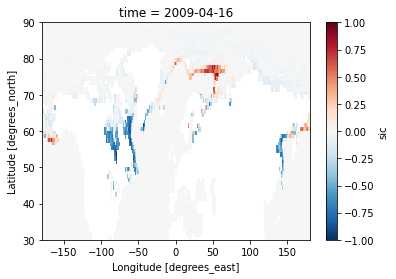

In [98]:
(HadISST1_30N.sel(time='2009-04') - HadISST1_30N.sel(time='2008-04').values).plot()

## From the reduced dataset and area file, compute the SIA and SIE

In [100]:
#open area file created from: cdo gridarea -selgrid,2 HadISST_ice.nc HadISST_ice_area.nc
HadISST1_areas = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST_ice_area.nc')
HadISST1_areas_NH = HadISST1_areas['cell_area'].where(HadISST1_areas['latitude']>30,drop=True) #select >30N

In [101]:
#compute SIA and SIE
NH_SIA = (HadISST1_30N * HadISST1_areas_NH / 1e12).sum('latitude').sum('longitude') 
NH_SIE = HadISST1_areas_NH.where(HadISST1_30N>=0.15,0).sum('latitude').sum('longitude') / 1e12

#save calculations to NetCDF
HadISST1_SIA_SIE = xr.Dataset({'SIA' : NH_SIA, 'SIE' : NH_SIE})

HadISST1_SIA_SIE.attrs = {'Description': 'Arctic sea ice area (SIA) and sea ice extent (SIE) from HadISST1 for all months 1979-2020, calculated using a grid area file from CDO. Note there is a large negative SIE and SIA anomaly for 2009-03 and 2009-04 which is not shown in other datasets', 
                          'Units'      : 'million square km',
                          'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                          'Data source': 'Hadley Centre Sea Ice and Sea Surface Temperature data set (HadISST), doi:10.1029/2002JD002670',
                          'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_calculations_observations.ipynb'}

HadISST1_SIA_SIE.to_netcdf(data_path+'Raw_data/observations/HadISST/HadISST1_SIA_SIE_79-20_discontinuity.nc')

## Interpolate 2009-03 and 2009-04 from CDR data, large negative anomalies for HadISST1

In [160]:
HadISST1_SIA_SIE = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST1_SIA_SIE_79-20_discontinuity.nc')

In [161]:
#now correct 2009-03 and 2009-04 with % change from NSIDC CDR
# % change from CDR
CDR_SIA_ch_02_to_03 = (CDR_SIA_SIE['CDR_SIA'].sel(time='2009-03').values - CDR_SIA_SIE['CDR_SIA'].sel(time='2009-02').values) / CDR_SIA_SIE['CDR_SIA'].sel(time='2009-02').values
CDR_SIA_ch_05_to_04 = (CDR_SIA_SIE['CDR_SIA'].sel(time='2009-04').values - CDR_SIA_SIE['CDR_SIA'].sel(time='2009-05').values) / CDR_SIA_SIE['CDR_SIA'].sel(time='2009-05').values

CDR_SIE_ch_02_to_03 = (CDR_SIA_SIE['CDR_SIE'].sel(time='2009-03').values - CDR_SIA_SIE['CDR_SIE'].sel(time='2009-02').values) / CDR_SIA_SIE['CDR_SIE'].sel(time='2009-02').values
CDR_SIE_ch_05_to_04 = (CDR_SIA_SIE['CDR_SIE'].sel(time='2009-04').values - CDR_SIA_SIE['CDR_SIE'].sel(time='2009-05').values) / CDR_SIA_SIE['CDR_SIE'].sel(time='2009-05').values

#calculate the % changes for HadISST1
SIA_corrected_03 = HadISST1_SIA_SIE['SIA'].sel(time='2009-02') * (1 + CDR_SIA_ch_02_to_03)
SIA_corrected_03['time'] = HadISST1_SIA_SIE['time'].sel(time='2009-03')
SIA_corrected_04 = HadISST1_SIA_SIE['SIA'].sel(time='2009-05') * (1 + CDR_SIA_ch_05_to_04)
SIA_corrected_04['time'] = HadISST1_SIA_SIE['time'].sel(time='2009-04')

SIE_corrected_03 = HadISST1_SIA_SIE['SIE'].sel(time='2009-02') * (1 + CDR_SIE_ch_02_to_03)
SIE_corrected_03['time'] = HadISST1_SIA_SIE['time'].sel(time='2009-03')
SIE_corrected_04 = HadISST1_SIA_SIE['SIE'].sel(time='2009-05') * (1 + CDR_SIE_ch_05_to_04)
SIE_corrected_04['time'] = HadISST1_SIA_SIE['time'].sel(time='2009-04')

In [162]:
SIA_corrected = xr.concat((HadISST1_SIA_SIE['SIA'].sel(time=slice('1979','2009-02')), SIA_corrected_03, SIA_corrected_04, HadISST1_SIA_SIE['SIA'].sel(time=slice('2009-05','2020'))), dim='time')
SIE_corrected = xr.concat((HadISST1_SIA_SIE['SIE'].sel(time=slice('1979','2009-02')), SIE_corrected_03, SIE_corrected_04, HadISST1_SIA_SIE['SIE'].sel(time=slice('2009-05','2020'))), dim='time')

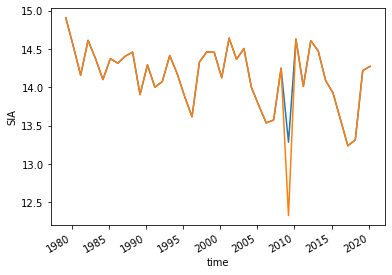

In [163]:
SIA_corrected.sel(time=SIA_corrected['time.month']==3).plot()
HadISST1_SIA_SIE['SIA'].sel(time=HadISST1_SIA_SIE['time.month']==3).plot()

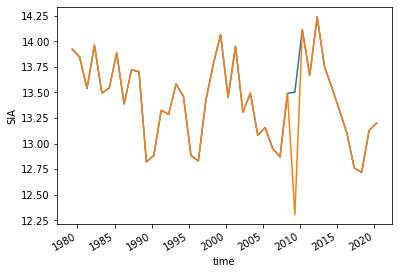

In [164]:
SIA_corrected.sel(time=SIA_corrected['time.month']==4).plot()
HadISST1_SIA_SIE['SIA'].sel(time=HadISST1_SIA_SIE['time.month']==4).plot()

In [138]:
#save calculations to NetCDF
HadISST1_SIA_SIE = xr.Dataset({'SIA' : SIA_corrected, 'SIE' : SIE_corrected})

HadISST1_SIA_SIE.attrs = {'Description': 'Arctic sea ice area (SIA) and sea ice extent (SIE) from HadISST1 for all months 1979-2020, calculated using a grid area file from CDO. Note 2009-03 and 2009-04 have large negative anomalies, these months are interpolated with NSIDC CDR data for % changes', 
                          'Units'      : 'million square km',
                          'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                          'Data source': 'Hadley Centre Sea Ice and Sea Surface Temperature data set (HadISST), doi:10.1029/2002JD002670',
                          'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_calculations_observations.ipynb'}

HadISST1_SIA_SIE.to_netcdf(data_path+'Raw_data/observations/HadISST/HadISST1_SIA_SIE_79-20.nc')

# HadISST2.2.0.0 - NOT USED CURRENTLY, MISSING DATA BEYOND 2020-08
- Make 1979-2020 SIC for all months, with non-sea ice set to np.nan
- Make SIE and SIA time series 

In [163]:
HadISST2 = xr.open_dataset(data_path+'Raw_data/observations/HadISST2/HadISST.2.2.0.0_sea_ice_concentration.nc')
HadISST2_79_20 = HadISST2['sic'].sel(time=slice('1979','2020')).where(HadISST2['latitude']>30, drop=True)
HadISST2_update = open(data_path+'Raw_data/observations/HadISST2/HadISST.2.2.0.0_sea_ice_concentration_update.txt', 'r')
HadISST2_update.read()
HadISST2_update = pd.read_csv(data_path+'Raw_data/observations/HadISST2/HadISST.2.2.0.0_sea_ice_concentration_update.txt', delim_whitespace=True, header=None)

# Merged Hadley-OI
- Make reduced dataset for 1979-2020, fill sea ice interpolated over land with np.nan using land mask from HadISST1 (same grid)
- Compute SIE and SIA time series for 1979-2020

In [13]:
Merged = xr.open_dataset(data_path+'Raw_data/observations/merged_Hadley_OI/MODEL.ICE.HAD187001-198110.OI198111-202103.nc')
Merged_30N = Merged['SEAICE'].sel(time=slice('1979','2020')).where(Merged['lat']>30,drop=True)

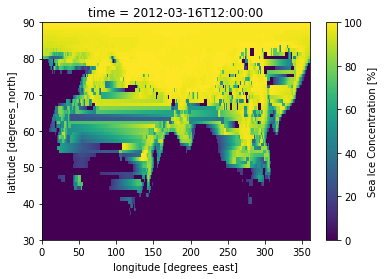

In [51]:
Merged_30N.sel(time='2012-03').plot()

In [31]:
#change lat and lon dimension to match HadISST1
Merged_new_coords = Merged_30N.copy()
Merged_new_coords['lon'] = Merged['lon'] - 180
Merged_new_coords_reversed = Merged_new_coords.reindex(lat=Merged_new_coords.lat[::-1])
Merged_new_coords_reversed = Merged_new_coords_reversed.transpose('lat', 'lon', 'time')
Merged_new_coords_reversed = Merged_new_coords_reversed.rename({'lat':'latitude', 'lon':'longitude'})

#maks the land using HadISST1 np.nan values
Merged_nans = Merged_new_coords_reversed.where(HadISST1_30N>-1)
#correct time to standard mid-month
Merged_nans['time'] = CLIVAR_time

In [139]:
#use the same area file as for HadISST1 
Merged_areas = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST_ice_area.nc')
Merged_areas_NH = Merged_areas['cell_area'].where(Merged_areas['latitude']>30,drop=True) #select >30N

#compute SIA and SIE
NH_SIA = (Merged_nans * Merged_areas_NH).sum('latitude').sum('longitude') / 1e14 #divide by 1e14 from % m2 to million km2
NH_SIE = Merged_areas_NH.where(Merged_nans>=15,0).sum('latitude').sum('longitude') / 1e12

#save calculations to NetCDF
Merged_SIA_SIE = xr.Dataset({'SIA' : NH_SIA, 'SIE' : NH_SIE})

Merged_SIA_SIE.attrs = {'Description': 'Arctic sea ice area (SIA) and sea ice extent (SIE) from Merged Hadley-OI for all months 1979-2020, calculated using a grid area file from CDO.', 
                        'Units'      : 'million square km',
                        'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                        'Data source': 'Merged Hadley-OI sea surface temperature and sea ice concentration data set, version 2.0, doi:10.5065/r33v-sv91',
                        'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_calculations_observations.ipynb'}

Merged_SIA_SIE.to_netcdf(data_path+'Raw_data/observations/merged_Hadley_OI/merged_Hadley_OI_SIA_SIE_79-20.nc')

# NSIDC Sea Ice Index V3
**N.B. Uses NASA Team (NT) algorithm data**
- Set pole hole to the concentration found in NT (SIC of the surrounding grid cells to the edge)
- Interpolate missing months with HadISST2 data

In [30]:
# First make an xarray object of the csv files for sea ice index
SIA_list = []
SIE_list = []

for i in np.arange(1,13):
    SII_month = xr.Dataset(pd.read_csv(data_path+'Raw_data/observations/NSIDC_sea_ice_index_v3/N_{}_extent_v3.0.csv'.format(str(i).zfill(2))))
    SII_month_SIA = SII_month['   area'].where(SII_month['   area']>0) #set missing values from -9999 to np.nan
    SII_month_SIE = SII_month[' extent'].where(SII_month[' extent']>0)
    
    SII_month_SIA['dim_0'] = np.arange('{}-{}'.format(SII_month['year'].min().values, str(i).zfill(2)), '{}-{}'.format(SII_month['year'].max().values+1, str(i).zfill(2)), 
                                       np.timedelta64(1,'Y'), dtype='datetime64[M]')
    SIA_list.append(SII_month_SIA.rename({'dim_0':'time'}))
    
    SII_month_SIE['dim_0'] = np.arange('{}-{}'.format(SII_month['year'].min().values, str(i).zfill(2)), '{}-{}'.format(SII_month['year'].max().values+1, str(i).zfill(2)), 
                                       np.timedelta64(1,'Y'), dtype='datetime64[M]')
    SIE_list.append(SII_month_SIE.rename({'dim_0':'time'}))

SIA_list_xr = xr.concat(SIA_list, dim='time')
SIE_list_xr = xr.concat(SIE_list, dim='time')

SIA_list_xr = SIA_list_xr.sortby('time')
SIE_list_xr = SIE_list_xr.sortby('time')

SIA_SIE_no_pole = xr.Dataset({'SIA': SIA_list_xr, 'SIE':SIE_list_xr})
SIA_SIE_no_pole = SIA_SIE_no_pole.sel(time=slice('1979','2020'))

SIA_SIE_no_pole['time'] = CLIVAR_time

In [20]:
# #interpolate the missing months 1987-08, 1987-12, 1988-01
# #SIA interpolation
# ph_SIA_SIE = xr.open_dataset(data_path+'Raw_data/observations/NSIDC_CDR_v4/pole_hole_SIA_edge_interpolated_CDR_BT_NT_79-20.nc')

# SIA_no_pole_1987_08 = SIA_SIE_no_pole['SIA'].sel(time='1987-07').values + (SIA_SIE_no_pole['SIA'].sel(time='1987-09').values - SIA_SIE_no_pole['SIA'].sel(time='1987-07').values)/2
# SIA_no_pole_1987_08 = xr.DataArray(data = SIA_no_pole_1987_08, coords={'time': CLIVAR_time.sel(time='1987-08').values}, dims=['time'])

# SIA_no_pole_1987_12 = SIA_SIE_no_pole['SIA'].sel(time='1987-11').values + (SIA_SIE_no_pole['SIA'].sel(time='1988-02').values - SIA_SIE_no_pole['SIA'].sel(time='1987-11').values)/3
# SIA_no_pole_1987_12 = xr.DataArray(data = SIA_no_pole_1987_12, coords={'time': CLIVAR_time.sel(time='1987-12').values}, dims=['time'])

# SIA_no_pole_1988_01 = SIA_SIE_no_pole['SIA'].sel(time='1988-02').values - ((SIA_SIE_no_pole['SIA'].sel(time='1988-02').values - SIA_SIE_no_pole['SIA'].sel(time='1987-11').values)/3)
# SIA_no_pole_1988_01 = xr.DataArray(data = SIA_no_pole_1988_01, coords={'time': CLIVAR_time.sel(time='1988-01').values}, dims=['time'])

# SIA_interp_no_pole = xr.concat((SIA_SIE_no_pole['SIA'].sel(time=slice('1979-01','1987-07')), SIA_no_pole_1987_08, SIA_SIE_no_pole['SIA'].sel(time=slice('1987-09','1987-11')), 
#                                 SIA_no_pole_1987_12, SIA_no_pole_1988_01, SIA_SIE_no_pole['SIA'].sel(time=slice('1988-02','2020-12'))), dim='time')

# #SIE interpolation
# SIE_no_pole_1987_12 = SIA_SIE_no_pole['SIE'].sel(time='1987-11').values + ((SIA_SIE_no_pole['SIE'].sel(time='1988-02').values - SIA_SIE_no_pole['SIE'].sel(time='1987-11').values)/3)
# SIE_no_pole_1987_12 = xr.DataArray(data = SIE_no_pole_1987_12, coords={'time': CLIVAR_time.sel(time='1987-12').values}, dims=['time'])

# SIE_no_pole_1988_01 = SIA_SIE_no_pole['SIE'].sel(time='1988-02').values - ((SIA_SIE_no_pole['SIE'].sel(time='1988-02').values - SIA_SIE_no_pole['SIE'].sel(time='1987-11').values)/3)
# SIE_no_pole_1988_01 = xr.DataArray(data = SIE_no_pole_1988_01, coords={'time': CLIVAR_time.sel(time='1988-01').values}, dims=['time'])

# SIE_interp_no_pole = xr.concat((SIA_SIE_no_pole['SIE'].sel(time=slice('1979-01','1987-11')), SIE_no_pole_1987_12, SIE_no_pole_1988_01, 
#                                 SIA_SIE_no_pole['SIE'].sel(time=slice('1988-02','2020-12'))), dim='time')

In [24]:
NT_SIA_no_ph = CDR_SIA_SIE['NT_SIA'] - ph_SIA_SIE['NT_SIA']

In [28]:

(NT_SIA_no_ph.sel(time='1987-12').values - NT_SIA_no_ph.sel(time='1987-11').values) / NT_SIA_no_ph.sel(time='1987-11').values

array([0.22613543], dtype=float32)

In [46]:
#interpolate missing months using NT SIA and SIE data calculated from SIC
#SIA interpolation
ph_SIA_SIE = xr.open_dataset(data_path+'Raw_data/observations/NSIDC_CDR_v4/pole_hole_SIA_edge_interpolated_CDR_BT_NT_79-20.nc')
NT_SIA_no_ph = CDR_SIA_SIE['NT_SIA'] - ph_SIA_SIE['NT_SIA']

SIA_no_pole_1987_08 = SIA_SIE_no_pole['SIA'].sel(time='1986-08').values * 1+((NT_SIA_no_ph.sel(time='1987-08').values - NT_SIA_no_ph.sel(time='1986-08').values) / NT_SIA_no_ph.sel(time='1986-08').values)
SIA_no_pole_1987_08 = xr.DataArray(data = SIA_no_pole_1987_08, coords={'time': CLIVAR_time.sel(time='1987-08').values}, dims=['time'])

SIA_no_pole_1987_12 = SIA_SIE_no_pole['SIA'].sel(time='1986-12').values * 1+((NT_SIA_no_ph.sel(time='1987-12').values - NT_SIA_no_ph.sel(time='1986-12').values) / NT_SIA_no_ph.sel(time='1986-12').values)
SIA_no_pole_1987_12 = xr.DataArray(data = SIA_no_pole_1987_12, coords={'time': CLIVAR_time.sel(time='1987-12').values}, dims=['time'])

SIA_no_pole_1988_01 = SIA_SIE_no_pole['SIA'].sel(time='1987-01').values * 1+((NT_SIA_no_ph.sel(time='1988-01').values - NT_SIA_no_ph.sel(time='1987-01').values) / NT_SIA_no_ph.sel(time='1987-01').values)
SIA_no_pole_1988_01 = xr.DataArray(data = SIA_no_pole_1988_01, coords={'time': CLIVAR_time.sel(time='1988-01').values}, dims=['time'])

SIA_interp_no_pole = xr.concat((SIA_SIE_no_pole['SIA'].sel(time=slice('1979-01','1987-07')), SIA_no_pole_1987_08, SIA_SIE_no_pole['SIA'].sel(time=slice('1987-09','1987-11')), 
                                SIA_no_pole_1987_12, SIA_no_pole_1988_01, SIA_SIE_no_pole['SIA'].sel(time=slice('1988-02','2020-12'))), dim='time')

#SIE interpolation
NT_SIE_no_ph = CDR_SIA_SIE['NT_SIE'] - ph_SIA_SIE['SIE']

SIE_no_pole_1987_12 = SIA_SIE_no_pole['SIE'].sel(time='1986-12').values * 1+((NT_SIE_no_ph.sel(time='1987-12').values - NT_SIE_no_ph.sel(time='1986-12').values) / NT_SIE_no_ph.sel(time='1986-12').values)
SIE_no_pole_1987_12 = xr.DataArray(data = SIE_no_pole_1987_12, coords={'time': CLIVAR_time.sel(time='1987-12').values}, dims=['time'])

print(((NT_SIE_no_ph.sel(time='1987-12').values - NT_SIE_no_ph.sel(time='1986-12').values) / NT_SIE_no_ph.sel(time='1986-12').values))


SIE_no_pole_1988_01 = SIA_SIE_no_pole['SIE'].sel(time='1987-01').values * 1+((NT_SIE_no_ph.sel(time='1988-01').values - NT_SIE_no_ph.sel(time='1987-01').values) / NT_SIE_no_ph.sel(time='1987-01').values)
SIE_no_pole_1988_01 = xr.DataArray(data = SIE_no_pole_1988_01, coords={'time': CLIVAR_time.sel(time='1988-01').values}, dims=['time'])

print((NT_SIE_no_ph.sel(time='1988-01').values - NT_SIE_no_ph.sel(time='1987-01').values) / NT_SIE_no_ph.sel(time='1987-01').values)

SIE_interp_no_pole = xr.concat((SIA_SIE_no_pole['SIE'].sel(time=slice('1979-01','1987-11')), SIE_no_pole_1987_12, SIE_no_pole_1988_01, 
                                SIA_SIE_no_pole['SIE'].sel(time=slice('1988-02','2020-12'))), dim='time')

[0.09289025]
[0.06845458]


In [39]:
#add the pole hole
SIA_interp = SIA_interp_no_pole + ph_SIA_SIE['NT_SIA']
SIE_interp = SIE_interp_no_pole + ph_SIA_SIE['SIE']

SIA_SIE_interp_index = xr.Dataset({'SIA':SIA_interp, 'SIE':SIE_interp})

In [40]:
#save the sea ice index to netcdf
SIA_SIE_interp_index.attrs = {'Description': 'Arctic sea ice area (SIA) and sea ice extent (SIE) including pole hole for NSIDC sea ice index vesion 3. All months 1979-2020, interpolation across previous and future year from linearly interpolated NT SIC data for missing months (1987-08, 1987-12, 1988-01).', 
                              'Units'      : 'million square km',
                              'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                              'Data source': 'NSIDC Sea Ice Index, Version 3,  doi:10.7265/N5K072F8.',
                              'Analysis'   : 'https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_calculations_observations.ipynb'}

SIA_SIE_interp_index.to_netcdf(data_path+'Raw_data/observations/NSIDC_sea_ice_index_v3/NSIDC_sea_ice_index_SIA_SIE_interpolated_with_pole_hole_79-20.nc')

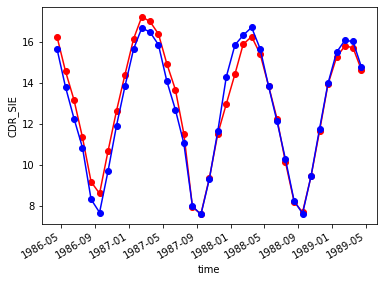

In [17]:
SIA_SIE_interp_index['SIE'].sel(time=slice('1986-04','1989-04')).plot(marker='o', c='r')
CDR_SIA_SIE['CDR_SIE'].sel(time=slice('1986-04','1989-04')).plot(marker='o', c='b')

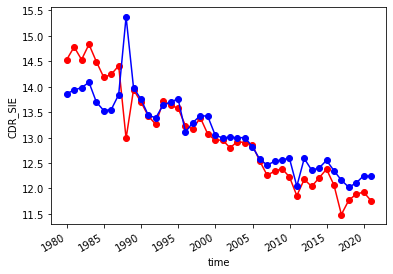

In [45]:
SIA_SIE_interp_index['SIE'].sel(time=SIA_SIE_interp_index['time.month']==12).plot(marker='o', c='r')
CDR_SIA_SIE['CDR_SIE'].sel(time=CDR_SIA_SIE['time.month']==12).plot(marker='o', c='b')

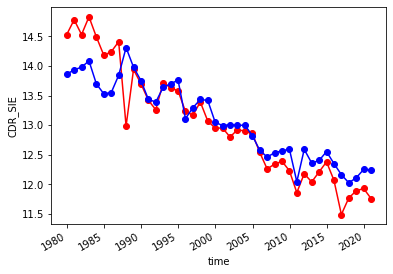

In [18]:
SIA_SIE_interp_index['SIE'].sel(time=SIA_SIE_interp_index['time.month']==12).plot(marker='o', c='r')
CDR_SIA_SIE['CDR_SIE'].sel(time=CDR_SIA_SIE['time.month']==12).plot(marker='o', c='b')

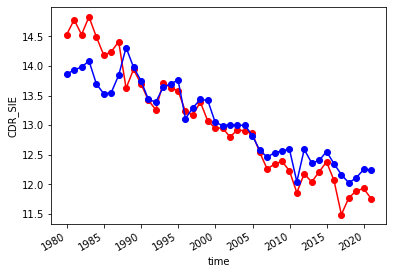

In [41]:
SIA_SIE_interp_index['SIE'].sel(time=SIA_SIE_interp_index['time.month']==12).plot(marker='o', c='r')
CDR_SIA_SIE['CDR_SIE'].sel(time=CDR_SIA_SIE['time.month']==12).plot(marker='o', c='b')

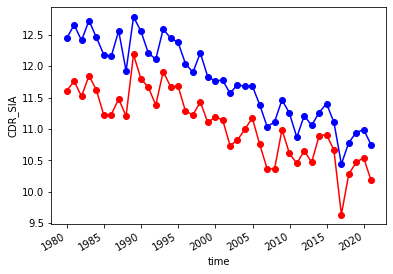

In [46]:
SIA_SIE_interp_index['SIA'].sel(time=SIA_SIE_interp_index['time.month']==12).plot(marker='o', c='r')
CDR_SIA_SIE['CDR_SIA'].sel(time=CDR_SIA_SIE['time.month']==12).plot(marker='o', c='b')

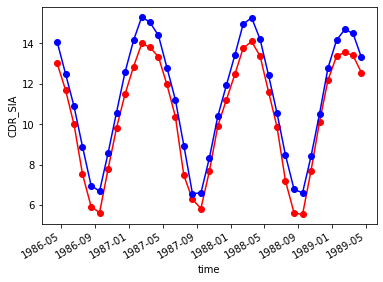

In [42]:
SIA_SIE_interp_index['SIA'].sel(time=slice('1986-04','1989-04')).plot(marker='o', c='r')
CDR_SIA_SIE['CDR_SIA'].sel(time=slice('1986-04','1989-04')).plot(marker='o', c='b')

# Compare all SIA and SIE from the different datasets

In [42]:
CDR_SIA_SIE.close()
SIA_SIE_interp_index.close()
# HadISST1_SIA_SIE.close()
# Merged_SIA_SIE.close()

CDR_SIA_SIE = xr.open_dataset(data_path+'Raw_data/observations/NSIDC_CDR_v4/SIA_SIE_CDR_BT_NT_79-20_interpolated.nc')
SIA_SIE_interp_index = xr.open_dataset(data_path+'Raw_data/observations/NSIDC_sea_ice_index_v3/NSIDC_sea_ice_index_SIA_SIE_interpolated_with_pole_hole_79-20.nc')
HadISST1_SIA_SIE = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST1_SIA_SIE_79-20.nc')
Merged_SIA_SIE = xr.open_dataset(data_path+'Raw_data/observations/merged_Hadley_OI/merged_Hadley_OI_SIA_SIE_79-20.nc')

In [43]:
average_SIA = (CDR_SIA_SIE['CDR_SIA'] + CDR_SIA_SIE['NT_SIA'] + CDR_SIA_SIE['BT_SIA'] + SIA_SIE_interp_index['SIA'] + HadISST1_SIA_SIE['SIA'] + Merged_SIA_SIE['SIA']) / 6
average_SIE = (CDR_SIA_SIE['CDR_SIE'] + CDR_SIA_SIE['NT_SIE'] + CDR_SIA_SIE['BT_SIE'] + SIA_SIE_interp_index['SIE'] + HadISST1_SIA_SIE['SIE'] + Merged_SIA_SIE['SIE']) / 6

In [44]:
import matplotlib.pyplot as plt
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
              'August', 'September', 'October', 'November', 'December']

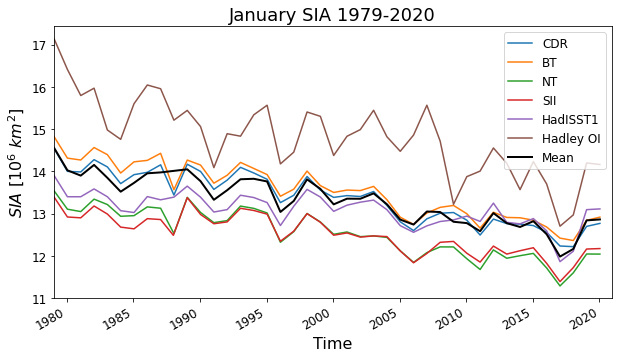

In [55]:
month_ = 1 
SIE_SIA = 'A'

plt.figure(figsize=[10,5])
CDR_SIA_SIE['CDR_SI{}'.format(SIE_SIA)].sel(time=CDR_SIA_SIE['time.month']==month_).plot(label='CDR')
CDR_SIA_SIE['BT_SI{}'.format(SIE_SIA)].sel(time=CDR_SIA_SIE['time.month']==month_).plot(label='BT')
CDR_SIA_SIE['NT_SI{}'.format(SIE_SIA)].sel(time=CDR_SIA_SIE['time.month']==month_).plot(label='NT')
SIA_SIE_interp_index['SI{}'.format(SIE_SIA)].sel(time=SIA_SIE_interp_index['time.month']==month_).plot(label='SII')
HadISST1_SIA_SIE['SI{}'.format(SIE_SIA)].sel(time=HadISST1_SIA_SIE['time.month']==month_).plot(label='HadISST1')
Merged_SIA_SIE['SI{}'.format(SIE_SIA)].sel(time=Merged_SIA_SIE['time.month']==month_).plot(label='Hadley OI')

average_SIA.sel(time=average_SIA['time.month']==month_).plot(label='Mean', c='k', linewidth=2)

plt.legend(fontsize=12)
plt.xlim(np.datetime64('1979-01'), np.datetime64('2020-12'))
plt.xticks(fontsize=12)
plt.xlabel('Time', fontsize=16)

plt.ylabel(r'$SI{} \ [10^6 \ km^2]$'.format(SIE_SIA), fontsize=16)
plt.yticks(fontsize=12)

plt.title('{} SI{} 1979-2020'.format(month_list[month_-1], SIE_SIA), fontsize=18);

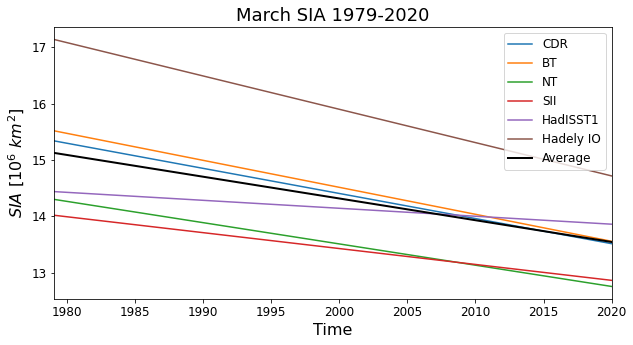

In [59]:
month_ = 3 
SIE_SIA = 'A'

plt.figure(figsize=[10,5])

coefs = np.polyfit(np.arange(1979,2021), CDR_SIA_SIE['CDR_SI{}'.format(SIE_SIA)].sel(time=CDR_SIA_SIE['time.month']==month_), 1)
plt.plot(np.arange(1979,2021), np.arange(1979,2021)*coefs[0] + coefs[1], label='CDR')

coefs = np.polyfit(np.arange(1979,2021), CDR_SIA_SIE['BT_SI{}'.format(SIE_SIA)].sel(time=CDR_SIA_SIE['time.month']==month_), 1)
plt.plot(np.arange(1979,2021), np.arange(1979,2021)*coefs[0] + coefs[1], label='BT')

coefs = np.polyfit(np.arange(1979,2021), CDR_SIA_SIE['NT_SI{}'.format(SIE_SIA)].sel(time=CDR_SIA_SIE['time.month']==month_), 1)
plt.plot(np.arange(1979,2021), np.arange(1979,2021)*coefs[0] + coefs[1], label='NT')

coefs = np.polyfit(np.arange(1979,2021), SIA_SIE_interp_index['SI{}'.format(SIE_SIA)].sel(time=SIA_SIE_interp_index['time.month']==month_), 1)
plt.plot(np.arange(1979,2021), np.arange(1979,2021)*coefs[0] + coefs[1], label='SII')

coefs = np.polyfit(np.arange(1979,2021), HadISST1_SIA_SIE['SI{}'.format(SIE_SIA)].sel(time=SIA_SIE_interp_index['time.month']==month_), 1)
plt.plot(np.arange(1979,2021), np.arange(1979,2021)*coefs[0] + coefs[1], label='HadISST1')

coefs = np.polyfit(np.arange(1979,2021), Merged_SIA_SIE['SI{}'.format(SIE_SIA)].sel(time=SIA_SIE_interp_index['time.month']==month_), 1)
plt.plot(np.arange(1979,2021), np.arange(1979,2021)*coefs[0] + coefs[1], label='Hadely IO')

coefs = np.polyfit(np.arange(1979,2021), average_SIA.sel(time=average_SIA['time.month']==month_), 1)
plt.plot(np.arange(1979,2021), np.arange(1979,2021)*coefs[0] + coefs[1], label='Average', c='k', linewidth=2)


plt.legend(fontsize=12)
plt.xlim(1979,2020)
plt.xticks(fontsize=12)
plt.xlabel('Time', fontsize=16)

plt.ylabel(r'$SI{} \ [10^6 \ km^2]$'.format(SIE_SIA), fontsize=16)
plt.yticks(fontsize=12)

plt.title('{} SI{} 1979-2020'.format(month_list[month_-1], SIE_SIA), fontsize=18);

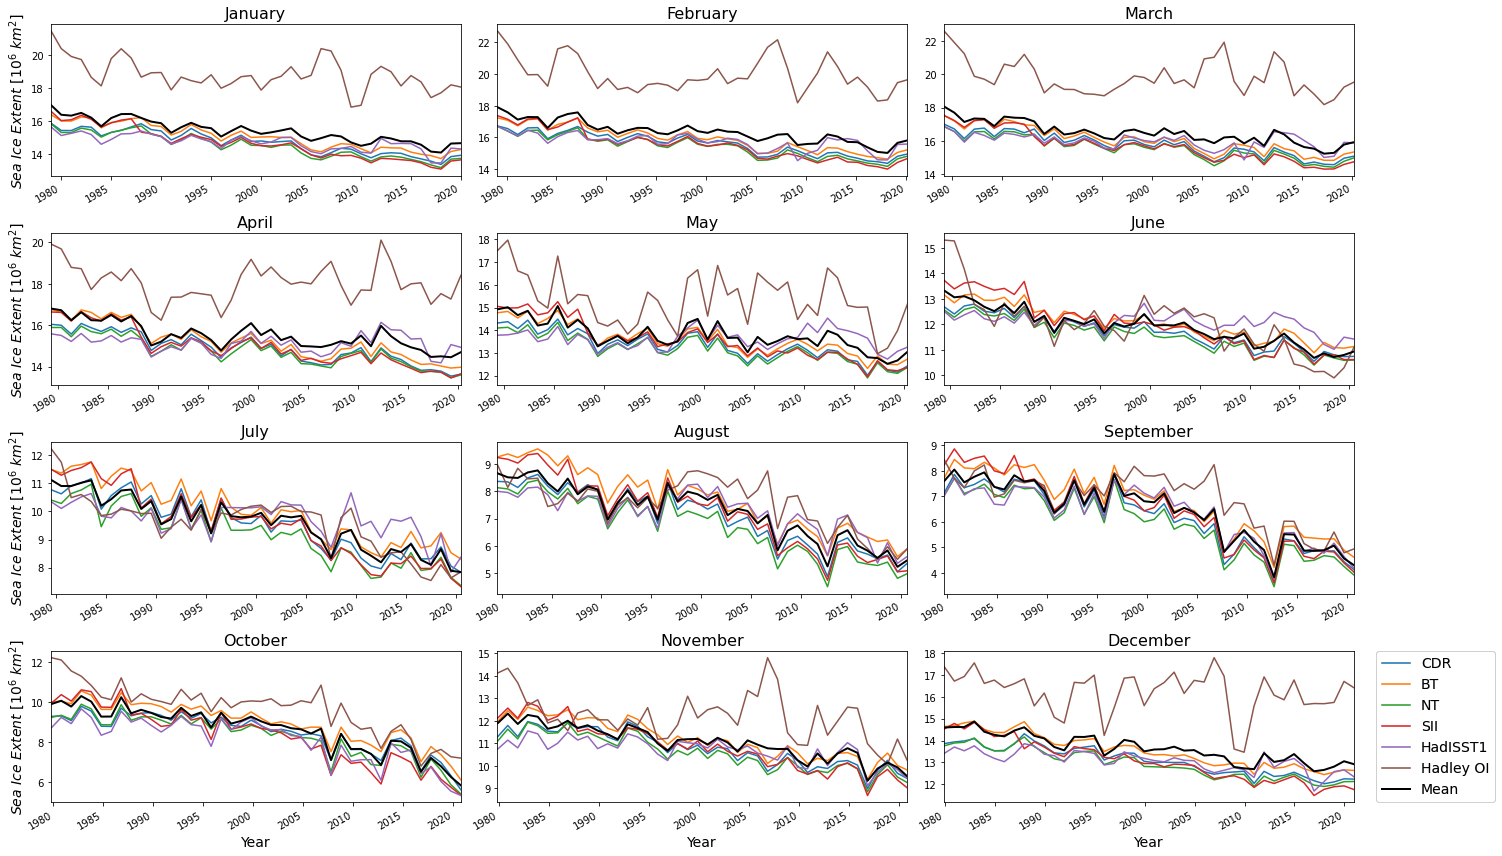

In [45]:
#plot for all of months
#axes counting
s_y = [0,1,2,0,1,2,0,1,2,0,1,2]
s_x = [0,0,0,1,1,1,2,2,2,3,3,3]

SIE_SIA = 'E'

if SIE_SIA == 'E':
    str_name = 'Extent'
    ave = average_SIE.copy()
else:
    str_name = 'Area'
    ave = average_SIA.copy()

fig, axes = plt.subplots(4,3,figsize=[19,12])

for month_i, month_ in enumerate(np.arange(1,13,1)):

    CDR_SIA_SIE['CDR_SI{}'.format(SIE_SIA)].sel(time=CDR_SIA_SIE['time.month']==month_).plot(label='CDR', ax=axes[s_x[month_i]][s_y[month_i]])
    CDR_SIA_SIE['BT_SI{}'.format(SIE_SIA)].sel(time=CDR_SIA_SIE['time.month']==month_).plot(label='BT', ax=axes[s_x[month_i]][s_y[month_i]])
    CDR_SIA_SIE['NT_SI{}'.format(SIE_SIA)].sel(time=CDR_SIA_SIE['time.month']==month_).plot(label='NT', ax=axes[s_x[month_i]][s_y[month_i]])
    SIA_SIE_interp_index['SI{}'.format(SIE_SIA)].sel(time=SIA_SIE_interp_index['time.month']==month_).plot(label='SII', ax=axes[s_x[month_i]][s_y[month_i]])
    HadISST1_SIA_SIE['SI{}'.format(SIE_SIA)].sel(time=HadISST1_SIA_SIE['time.month']==month_).plot(label='HadISST1', ax=axes[s_x[month_i]][s_y[month_i]])
    Merged_SIA_SIE['SI{}'.format(SIE_SIA)].sel(time=Merged_SIA_SIE['time.month']==month_).plot(label='Hadley OI', ax=axes[s_x[month_i]][s_y[month_i]])
        
    ave.sel(time=ave['time.month']==month_).plot(label='Mean', c='k', linewidth=2, ax=axes[s_x[month_i]][s_y[month_i]])
    
    axes[s_x[month_i]][s_y[month_i]].set_xlim(np.datetime64('1979-{}'.format(str(month_).zfill(2))), 
                                              np.datetime64('2020-{}'.format(str(month_).zfill(2))))
    
    axes[s_x[month_i]][s_y[month_i]].set_title(month_list[month_-1], fontsize=16)
    axes[s_x[month_i]][s_y[month_i]].set_xlabel('')
    
    if s_x[month_i] == 3:
        axes[s_x[month_i]][s_y[month_i]].set_xlabel('Year', fontsize=14)
    if s_y[month_i] == 0:
        axes[s_x[month_i]][s_y[month_i]].set_ylabel(r'$Sea \ Ice \ {} \ [10^6 \ km^2]$'.format(str_name), fontsize=14)
        
    plt.tight_layout()
    
extra_legend = plt.legend(bbox_to_anchor=(1.2, 1), loc='upper center', borderaxespad=0, ncol=1, fontsize=14)
plt.gca().add_artist(extra_legend);

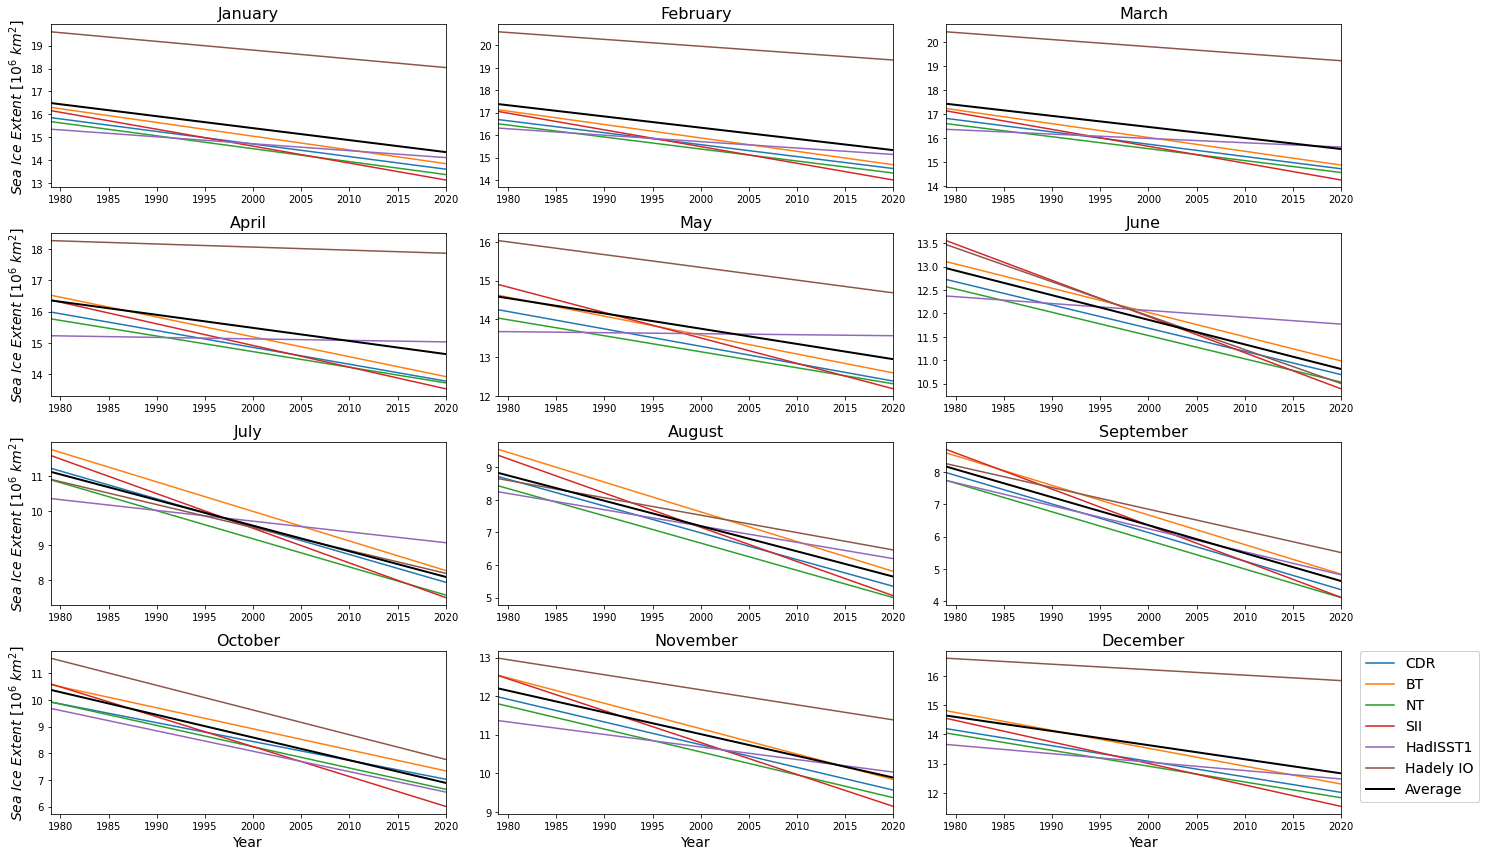

In [31]:
s_y = [0,1,2,0,1,2,0,1,2,0,1,2]
s_x = [0,0,0,1,1,1,2,2,2,3,3,3]

SIE_SIA = 'E'

if SIE_SIA == 'E':
    str_name = 'Extent'
    ave = average_SIE.copy()
else:
    str_name = 'Area'
    ave = average_SIA.copy()

fig, axes = plt.subplots(4,3,figsize=[19,12])

for month_i, month_ in enumerate(np.arange(1,13,1)):

    coefs = np.polyfit(np.arange(1979,2021), CDR_SIA_SIE['CDR_SI{}'.format(SIE_SIA)].sel(time=CDR_SIA_SIE['time.month']==month_), 1)
    axes[s_x[month_i]][s_y[month_i]].plot(np.arange(1979,2021), np.arange(1979,2021)*coefs[0] + coefs[1], label='CDR')

    coefs = np.polyfit(np.arange(1979,2021), CDR_SIA_SIE['BT_SI{}'.format(SIE_SIA)].sel(time=CDR_SIA_SIE['time.month']==month_), 1)
    axes[s_x[month_i]][s_y[month_i]].plot(np.arange(1979,2021), np.arange(1979,2021)*coefs[0] + coefs[1], label='BT')

    coefs = np.polyfit(np.arange(1979,2021), CDR_SIA_SIE['NT_SI{}'.format(SIE_SIA)].sel(time=CDR_SIA_SIE['time.month']==month_), 1)
    axes[s_x[month_i]][s_y[month_i]].plot(np.arange(1979,2021), np.arange(1979,2021)*coefs[0] + coefs[1], label='NT')

    coefs = np.polyfit(np.arange(1979,2021), SIA_SIE_interp_index['SI{}'.format(SIE_SIA)].sel(time=SIA_SIE_interp_index['time.month']==month_), 1)
    axes[s_x[month_i]][s_y[month_i]].plot(np.arange(1979,2021), np.arange(1979,2021)*coefs[0] + coefs[1], label='SII')

    coefs = np.polyfit(np.arange(1979,2021), HadISST1_SIA_SIE['SI{}'.format(SIE_SIA)].sel(time=SIA_SIE_interp_index['time.month']==month_), 1)
    axes[s_x[month_i]][s_y[month_i]].plot(np.arange(1979,2021), np.arange(1979,2021)*coefs[0] + coefs[1], label='HadISST1')

    coefs = np.polyfit(np.arange(1979,2021), Merged_SIA_SIE['SI{}'.format(SIE_SIA)].sel(time=SIA_SIE_interp_index['time.month']==month_), 1)
    axes[s_x[month_i]][s_y[month_i]].plot(np.arange(1979,2021), np.arange(1979,2021)*coefs[0] + coefs[1], label='Hadely IO')

    try:
        coefs = np.polyfit(np.arange(1979,2021), ave.sel(time=ave['time.month']==month_), 1)
        axes[s_x[month_i]][s_y[month_i]].plot(np.arange(1979,2021), np.arange(1979,2021)*coefs[0] + coefs[1], label='Average', c='k', linewidth=2)
    except(TypeError):
        pass        
    
    axes[s_x[month_i]][s_y[month_i]].set_xlim(1979,2020)
    
    axes[s_x[month_i]][s_y[month_i]].set_title(month_list[month_-1], fontsize=16)
    axes[s_x[month_i]][s_y[month_i]].set_xlabel('')
    
    if s_x[month_i] == 3:
        axes[s_x[month_i]][s_y[month_i]].set_xlabel('Year', fontsize=14)
    if s_y[month_i] == 0:
        axes[s_x[month_i]][s_y[month_i]].set_ylabel(r'$Sea \ Ice \ {} \ [10^6 \ km^2]$'.format(str_name), fontsize=14)
        
    plt.tight_layout()
    
extra_legend = plt.legend(bbox_to_anchor=(1.2, 1), loc='upper center', borderaxespad=0, ncol=1, fontsize=14)
plt.gca().add_artist(extra_legend);